# Urban Traffic Anomaly Detection using Variational Autoencoders (VAE)

In this project, we aim to detect anomalies in urban traffic patterns using a probabilistic machine learning approach based on Variational Autoencoders (VAE). 

We will train the VAE on typical traffic data so that it learns common patterns. Then, we will detect anomalies as deviations from these learned patterns.

The dataset used is the METR-LA dataset, which contains traffic speed readings from sensors in Los Angeles collected every 5 minutes.


## Environment Setup

We will use Python 3.8+ and the following key libraries:

- `h5py`: to read `.h5` dataset files  
- `tables` (PyTables): a dependency needed by `pandas` to handle HDF5 files  
- `numpy` and `pandas`: for data manipulation  
- `matplotlib`: for visualization  
- `torch` (PyTorch): to build and train our VAE model  

### Installing required packages

You can install them via pip:

```bash
pip install numpy pandas matplotlib h5py tables torch


## Data Description


**METR-LA Dataset**

- Contains traffic speed data from 207 sensors in Los Angeles.
- Data is recorded every 5 minutes, resulting in 12 records per hour.
- The data is stored in an HDF5 file format (`metr-la.h5`), where rows represent timestamps and columns correspond to different sensors.
- Additionally, a precomputed sensor graph adjacency matrix is provided (`adj_mx.pkl`) which encodes the spatial relations between sensors.

The data shape is approximately (34272, 207), meaning 34,272 time steps and 207 sensors.


## Data Loading and Preprocessing

We will load the data from the `.h5` file using `h5py`, normalize the data, and create sliding windows of size 12 (1 hour of data).

In [2]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Ruta al archivo .h5
file_path = 'data/metr-la.h5'
df = pd.read_hdf(file_path)
print(df.shape)
print(df.head)
print(df.tail)

(34272, 207)
<bound method NDFrame.head of                         773869     767541     767542     717447     717446  \
2012-03-01 00:00:00  64.375000  67.625000  67.125000  61.500000  66.875000   
2012-03-01 00:05:00  62.666667  68.555556  65.444444  62.444444  64.444444   
2012-03-01 00:10:00  64.000000  63.750000  60.000000  59.000000  66.500000   
2012-03-01 00:15:00   0.000000   0.000000   0.000000   0.000000   0.000000   
2012-03-01 00:20:00   0.000000   0.000000   0.000000   0.000000   0.000000   
...                        ...        ...        ...        ...        ...   
2012-06-27 23:35:00  65.000000  65.888889  68.555556  61.666667   0.000000   
2012-06-27 23:40:00  61.375000  65.625000  66.500000  62.750000   0.000000   
2012-06-27 23:45:00  67.000000  59.666667  69.555556  61.000000   0.000000   
2012-06-27 23:50:00  66.750000  62.250000  66.000000  59.625000   0.000000   
2012-06-27 23:55:00  65.111111  66.888889  66.777778  61.222222   0.000000   

                    

                     hour_sin  hour_cos   dow_sin   dow_cos  month_sin  \
2012-03-01 00:00:00       0.0       1.0  0.433884 -0.900969        1.0   
2012-03-01 00:05:00       0.0       1.0  0.433884 -0.900969        1.0   
2012-03-01 00:10:00       0.0       1.0  0.433884 -0.900969        1.0   
2012-03-01 00:15:00       0.0       1.0  0.433884 -0.900969        1.0   
2012-03-01 00:20:00       0.0       1.0  0.433884 -0.900969        1.0   

                        month_cos  
2012-03-01 00:00:00  6.123234e-17  
2012-03-01 00:05:00  6.123234e-17  
2012-03-01 00:10:00  6.123234e-17  
2012-03-01 00:15:00  6.123234e-17  
2012-03-01 00:20:00  6.123234e-17  


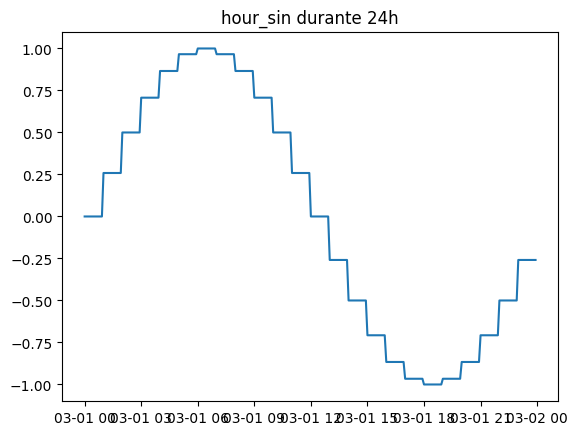

In [3]:
# --- Variables de tiempo como condiciones ---
df.index = pd.to_datetime(df.index)
df_time = pd.DataFrame(index=df.index)

# Hora del día (0-23) → ciclo de 24h
df_time["hour_sin"] = np.sin(2 * np.pi * df.index.hour / 24)
df_time["hour_cos"] = np.cos(2 * np.pi * df.index.hour / 24)

# Día de la semana (0=lunes, 6=domingo)
df_time["dow_sin"] = np.sin(2 * np.pi * df.index.dayofweek / 7)
df_time["dow_cos"] = np.cos(2 * np.pi * df.index.dayofweek / 7)

# Mes (1-12)
df_time["month_sin"] = np.sin(2 * np.pi * df.index.month / 12)
df_time["month_cos"] = np.cos(2 * np.pi * df.index.month / 12)

print(df_time.head())
import matplotlib.pyplot as plt

plt.plot(df_time["hour_sin"][:288])  # 1 día si son datos cada 5 minutos
plt.title("hour_sin durante 24h")
plt.show()

In [4]:
x = df.values.astype(np.float32)
c = df_time.values.astype(np.float32)
print(len(x))

34272


We use `StandardScaler` from scikit-learn to apply Z-score normalization to the dataset.

Each sensor (column) is standardized independently by removing the mean and scaling to unit variance:

$$
x_{\text{normalized}} = \frac{x - \mu}{\sigma}
$$

In [5]:
from sklearn.preprocessing import StandardScaler

x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=0.2, shuffle=False)
scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)
print(len(x_test))

scaler_c = StandardScaler()
c_train = scaler_c.fit_transform(c_train)
c_test = scaler_c.transform(c_test)

6855


## Static Conditional Variational Autoencoder (CVAE)

A **Conditional Variational Autoencoder (CVAE)** is a generative neural network that reconstructs or generates data samples based on both an input `x` and additional context or condition `c` (e.g., time, event type, etc.).

Unlike recurrent or sequential models, a **static CVAE** assumes that each data point is independent, without modeling temporal relationships.

#### Main Components

- **Input (`x`)**: The data to be reconstructed (e.g., sensor readings).
- **Condition (`c`)**: Extra information that provides context (e.g., timestamp, holiday flag).
- **Encoder**: Maps `x` and `c` into a latent distribution `z ~ q(z|x, c)`.
- **Latent space (`z`)**: A compressed, learned representation of the input data.
- **Decoder**: Uses `z` and `c` to reconstruct the input: `x̂ = p(x|z, c)`.

We define a custom `TrafficDataset` to prepare our data in a format compatible with PyTorch's `DataLoader`.

This class:
- Converts the input features (`x`) and conditions (`c`) into tensors.
- Allows easy indexing and batching of the data.
- Returns tuples `(x, c)` so both the data and its condition can be used during model training.

Using a custom dataset class ensures full control over how data is structured and accessed during training and testing.

In [6]:
# --- Dataset personalizado ---
class TrafficDataset(Dataset):
    def __init__(self, x, c):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.c = torch.tensor(c, dtype=torch.float32)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.c[idx]

train_dataset = TrafficDataset(x_train, c_train)
test_dataset = TrafficDataset(x_test, c_test)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
# --- CVAE base (sin LSTM por ahora) estático ---
class CVAE(nn.Module):
    def __init__(self, input_dim, cond_dim, latent_dim=16):
        super(CVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + cond_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + cond_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def encode(self, x, c):
        h = self.encoder(torch.cat([x, c], dim=1))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        return self.decoder(torch.cat([z, c], dim=1))

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z, c)
        return x_recon, mu, logvar

In [8]:
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.MSELoss()(recon_x, x)
    kl_loss = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
    return recon_loss + kl_loss, recon_loss, kl_loss


In [9]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = x_train.shape[1]
cond_dim = c_train.shape[1]
latent_dim = 16

model = CVAE(input_dim, cond_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss, total_recon, total_kl = 0, 0, 0

    for x_batch, c_batch in train_loader:
        x_batch, c_batch = x_batch.to(device), c_batch.to(device)

        optimizer.zero_grad()
        x_recon, mu, logvar = model(x_batch, c_batch)
        loss, recon_loss, kl_loss = loss_function(x_recon, x_batch, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x_batch.size(0)
        total_recon += recon_loss.item() * x_batch.size(0)
        total_kl += kl_loss.item() * x_batch.size(0)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss/len(train_loader.dataset):.4f} | Recon: {total_recon/len(train_loader.dataset):.4f} | KL: {total_kl/len(train_loader.dataset):.4f}")


Epoch 1/50 - Loss: 0.9293 | Recon: 0.9205 | KL: 0.0088
Epoch 2/50 - Loss: 0.8186 | Recon: 0.7497 | KL: 0.0689
Epoch 3/50 - Loss: 0.7102 | Recon: 0.5311 | KL: 0.1792
Epoch 4/50 - Loss: 0.6888 | Recon: 0.4914 | KL: 0.1974
Epoch 5/50 - Loss: 0.6485 | Recon: 0.4569 | KL: 0.1916
Epoch 6/50 - Loss: 0.6152 | Recon: 0.4166 | KL: 0.1986
Epoch 7/50 - Loss: 0.5882 | Recon: 0.3879 | KL: 0.2003
Epoch 8/50 - Loss: 0.5773 | Recon: 0.3752 | KL: 0.2022
Epoch 9/50 - Loss: 0.5652 | Recon: 0.3664 | KL: 0.1988
Epoch 10/50 - Loss: 0.5655 | Recon: 0.3668 | KL: 0.1988
Epoch 11/50 - Loss: 0.5561 | Recon: 0.3616 | KL: 0.1945
Epoch 12/50 - Loss: 0.5552 | Recon: 0.3590 | KL: 0.1962
Epoch 13/50 - Loss: 0.5495 | Recon: 0.3563 | KL: 0.1933
Epoch 14/50 - Loss: 0.5461 | Recon: 0.3535 | KL: 0.1926
Epoch 15/50 - Loss: 0.5499 | Recon: 0.3565 | KL: 0.1934
Epoch 16/50 - Loss: 0.5414 | Recon: 0.3502 | KL: 0.1912
Epoch 17/50 - Loss: 0.5383 | Recon: 0.3520 | KL: 0.1864
Epoch 18/50 - Loss: 0.5381 | Recon: 0.3456 | KL: 0.1925
E

In [10]:
# Recosntruir todas las velocidades del set de test
reconstructed = []
originals = []

with torch.no_grad():
    for x_batch, c_batch in test_loader:
        x_batch, c_batch = x_batch.to(device), c_batch.to(device)
        x_recon, _, _ = model(x_batch, c_batch)
        reconstructed.append(x_recon.cpu())
        originals.append(x_batch.cpu())

x_recon_all = torch.cat(reconstructed, dim=0)  # [6854, 207]
x_orig_all = torch.cat(originals, dim=0)       # [6854, 207]
print(x_recon_all.shape)
print(x_orig_all.shape)

torch.Size([6855, 207])
torch.Size([6855, 207])


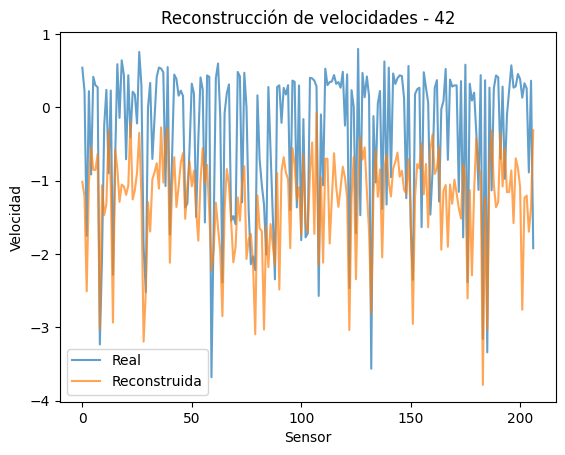

In [11]:
import matplotlib.pyplot as plt

index_sample = 42  # elige un índice de muestra
plt.plot(x_orig_all[index_sample], label="Real", alpha=0.7)
plt.plot(x_recon_all[index_sample], label="Reconstruida", alpha=0.7)
plt.title(f"Reconstrucción de velocidades - {index_sample}")
plt.xlabel("Sensor")
plt.ylabel("Velocidad")
plt.legend()
plt.show()


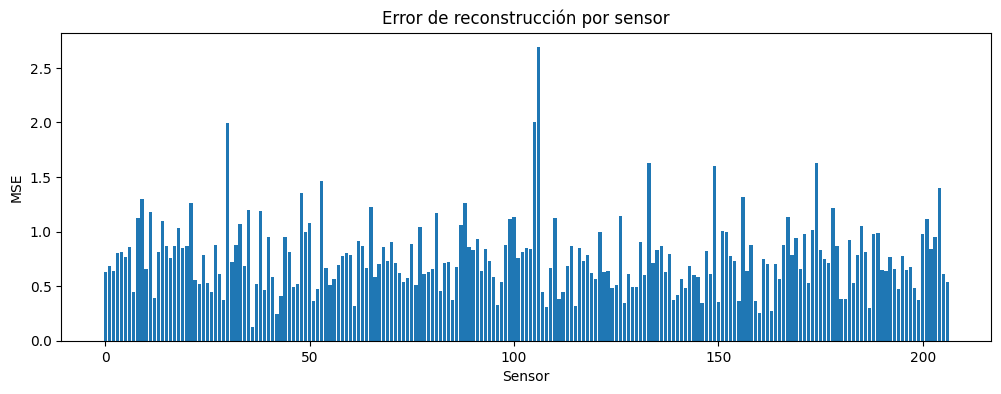

torch.Size([207])


In [ ]:
mse_by_sensor = torch.mean((x_recon_all[0:12] - x_orig_all[0:12])**2, dim=0) # we can compute the mse on a window

plt.figure(figsize=(12, 4))
plt.bar(range(207), mse_by_sensor)
plt.title("Error de reconstrucción por sensor")
plt.xlabel("Sensor")
plt.ylabel("MSE")
plt.show()

print(mse_by_sensor.shape)


In [23]:
import matplotlib.dates as mdates
# MSE por muestra y por sensor (shape: [n_muestras, n_sensores])
mse_matrix = (x_orig_all - x_recon_all) ** 2  # tensor shape: [N, 207]
print(mse_matrix.shape)

# Cálculo del umbral por sensor (p. ej., media + 3*std)
#mean_mse = mse_matrix.mean(dim=0)
#std_mse = mse_matrix.std(dim=0)
#thresholds = mean_mse + 3 * std_mse  # umbral por sensor
# Umbral por sensor usando percentil (ej: 99.5)
thresholds = torch.quantile(mse_matrix, 0.995, dim=0)


# Detección (matriz booleana: True = anómalo)
anomalies = mse_matrix > thresholds
anomalous_counts = anomalies.sum(dim=1)  # cuenta cuántos sensores anómalos hay por muestra

# Timestamps del conjunto de test
print("Inicio del test:", df.index[-len(x_test)])
print("Fin del test:", df.index[-1])
test_timestamps = df.index[-len(x_test):]

torch.Size([6855, 207])
Inicio del test: 2012-06-04 04:45:00
Fin del test: 2012-06-27 23:55:00


In [ ]:
import torch

# Si anomalous_counts es un tensor de PyTorch
top_indices = torch.topk(anomalous_counts, 10).indices

print("Top timestamps con más anomalías:")
for idx in top_indices:
    ts = test_timestamps[idx.item()]
    count = anomalous_counts[idx].item()
    print(f"Índice: {idx.item()} → Fecha: {ts} → Sensores anómalos: {count}")

# for idx in top_indices:
#     ts = test_timestamps[idx.item()]
#     count = anomalous_counts[idx].item()
#     sensors = anomalies[idx].nonzero().squeeze().tolist()
#     if isinstance(sensors, int):  # caso de un solo sensor
#         sensors = [sensors]
#     print(f"\nFecha: {ts} → {count} sensores anómalos")
#     print("Sensores:", sensors)


Top timestamps con más anomalías:
Índice: 4969 → Fecha: 2012-06-21 10:50:00 → Sensores anómalos: 189
Índice: 4968 → Fecha: 2012-06-21 10:45:00 → Sensores anómalos: 185
Índice: 2909 → Fecha: 2012-06-14 07:10:00 → Sensores anómalos: 181
Índice: 2949 → Fecha: 2012-06-14 10:30:00 → Sensores anómalos: 173
Índice: 4935 → Fecha: 2012-06-21 08:00:00 → Sensores anómalos: 171
Índice: 4946 → Fecha: 2012-06-21 08:55:00 → Sensores anómalos: 169
Índice: 4957 → Fecha: 2012-06-21 09:50:00 → Sensores anómalos: 164
Índice: 4950 → Fecha: 2012-06-21 09:15:00 → Sensores anómalos: 163
Índice: 892 → Fecha: 2012-06-07 07:05:00 → Sensores anómalos: 163
Índice: 4936 → Fecha: 2012-06-21 08:05:00 → Sensores anómalos: 161

Fecha: 2012-06-21 10:50:00 → 189 sensores anómalos
Sensores: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 

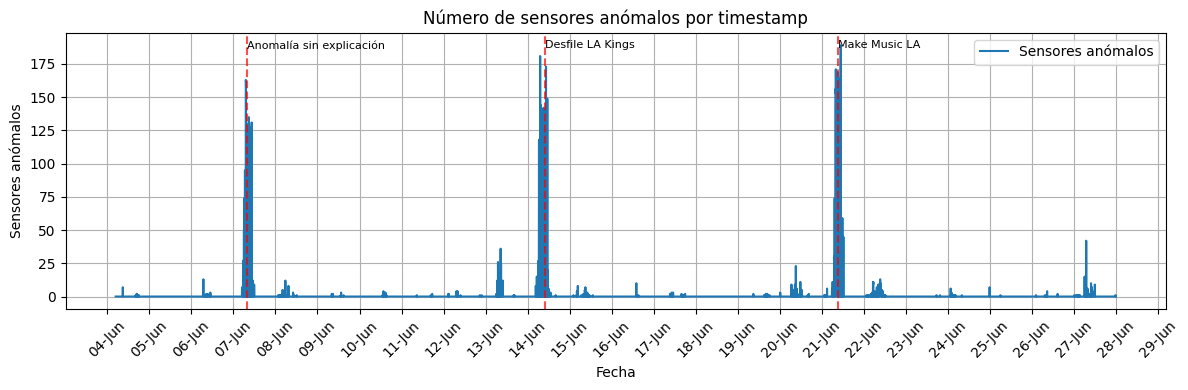

In [25]:
# --- Visualización con fechas y eventos ---
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(test_timestamps, anomalous_counts, label='Sensores anómalos')

# Formatear el eje X para mostrar fechas
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Mostrar cada 2 días
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

# Añadir líneas y etiquetas para eventos importantes
event_dates = {
    'Desfile LA Kings': pd.to_datetime('2012-06-14 09:55:00'),
    'Make Music LA': pd.to_datetime('2012-06-21 09:10:00'),
    'Anomalía sin explicación': pd.to_datetime('2012-06-07 07:35:00')
}

for label, date in event_dates.items():
    ax.axvline(date, color='red', linestyle='--', alpha=0.7)
    ax.text(date, max(anomalous_counts), label,
            rotation=0, verticalalignment='center', fontsize=8)

# Mejoras visuales
plt.title("Número de sensores anómalos por timestamp")
plt.xlabel("Fecha")
plt.ylabel("Sensores anómalos")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

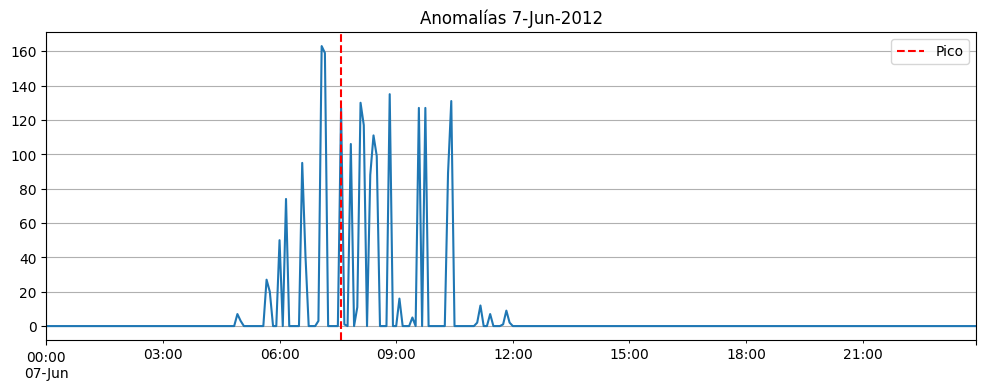

In [26]:
import pandas as pd

# Convertimos el tensor de anomalías en un DataFrame con índice de timestamps
df_anom = pd.DataFrame(anomalies.numpy(), index=test_timestamps)
df_anom.index = pd.to_datetime(df_anom.index)  # Asegura tipo datetime
df_anom.index = pd.DatetimeIndex(df_anom.index.values)
# Filtra por el día 7
df_anom_7jun = df_anom.loc["2012-06-07"]
# 3) Continúa con tu análisis
conteo = df_anom_7jun.sum(axis=1)
conteo.index.freq = None
conteo.plot(figsize=(12,4), title="Anomalías 7-Jun-2012")
plt.axvline(pd.Timestamp("2012-06-07 07:35"), linestyle="--", label="Pico", color="red")
plt.legend(); plt.grid(); plt.show()

In [ ]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

# 1. Crear el DataFrame de anomalías por timestamp
df_anom = pd.DataFrame({
    'timestamp': test_timestamps,
    'anomaly_count': anomalous_counts
})
df_anom['date'] = df_anom['timestamp'].dt.date

# 2. Generar fechas de festivos federales
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=df_anom['date'].min(),
                        end=df_anom['date'].max()).date

# 3. Agregar eventos especiales conocidos (no festivos pero relevantes)
special_event_dates = pd.to_datetime([
    '2012-06-14',  # LA Kings Victory Parade
    '2012-06-21',  # Make Music LA + Silicon Beach Fest
]).date

# 4. Marcar días especiales y festivos
df_anom['is_special'] = df_anom['date'].isin(holidays) | df_anom['date'].isin(special_event_dates)


# 5. Agrupar por tipo de día
summary = df_anom.groupby('is_special')['anomaly_count'] \
                 .agg(['count', 'mean', 'sum']) \
                 .rename(index={True: 'timestamp especial/festivo', False: 'timestamp normal'})

print("Resumen de anomalías en días normales vs. días especiales/festivos:")
print(summary)



Resumen de anomalías en días normales vs. días especiales/festivos:
                      count      mean   sum
is_special                                 
Día normal             6279  0.463768  2912
Día especial/festivo    576  7.522569  4333


## Resumen de anomalías en días normales vs. días especiales/festivos

| Tipo de día           | Cantidad de registros (`count`) | Promedio de anomalías por registro (`mean`) | Total de anomalías (`sum`) |
|-----------------------|---------------------------------|---------------------------------------------|----------------------------|
| Día normal            | 6,279                           | 0.46                                        | 2,912                      |
| Día especial/festivo  | 576                             | 7.52                                        | 4,333                      |

### Interpretación:

- **Día normal:**  
  Hay 6,279 registros o timestamps en días normales.  
  En promedio, cada registro tiene aproximadamente 0.46 anomalías.  
  En total, durante estos días normales se detectaron 2,912 anomalías.

- **Día especial/festivo:**  
  Hay 576 registros en días que son festivos o eventos especiales.  
  En promedio, cada registro presenta muchas más anomalías, aproximadamente 7.52.  
  En total, en estos pocos días especiales se detectaron 4,333 anomalías.

### Conclusión:

Aunque la cantidad de registros en días normales es mucho mayor, la cantidad y promedio de anomalías es significativamente más alto en los días especiales o festivos. Esto indica que estos días tienen un impacto fuerte en la aparición de anomalías, lo cual es relevante para análisis o modelado que quiera tener en cuenta el efecto de eventos especiales.


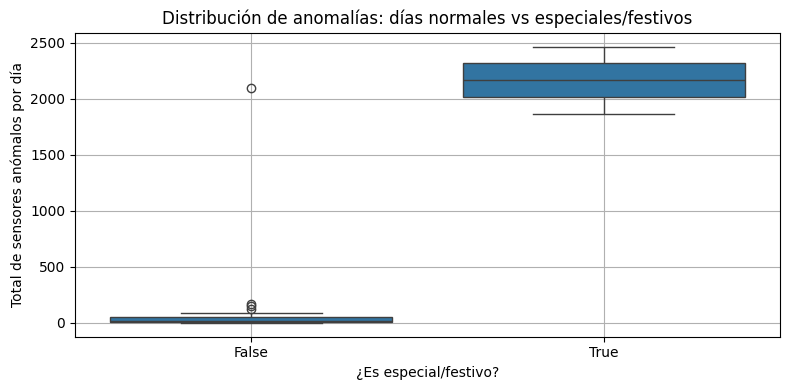

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Agregamos totales por día
daily_anomalies = df_anom.groupby('date')['anomaly_count'].sum().reset_index()
daily_anomalies['is_special'] = daily_anomalies['date'].isin(holidays) | daily_anomalies['date'].isin(special_event_dates)

# Visualización
plt.figure(figsize=(8, 4))
sns.boxplot(data=daily_anomalies, x='is_special', y='anomaly_count')
plt.title("Distribución de anomalías: días normales vs especiales/festivos")
plt.xlabel("¿Es especial/festivo?")
plt.ylabel("Total de sensores anómalos por día")
plt.grid(True)
plt.tight_layout()
plt.show()


In [30]:
import torch

# Escoge los índices con más sensores anómalos (ej. top 10)
top_indices = torch.topk(anomalous_counts, k=10).indices

# Contador de sensores más frecuentes en esos timestamps anómalos
sensor_counts = torch.zeros(anomalies.shape[1])

# Sumar cuántas veces cada sensor fue anómalo en esos top timestamps
for idx in top_indices:
    sensor_counts += anomalies[idx].float()

# Obtener los sensores más repetidos
top_sensor_indices = torch.topk(sensor_counts, k=10).indices
print("Sensores más frecuentes en los picos de anomalía:", top_sensor_indices.tolist())


Sensores más frecuentes en los picos de anomalía: [0, 1, 2, 203, 204, 206, 6, 7, 181, 104]


In [56]:
import pandas as pd
import folium

# Cargar las ubicaciones de los sensores
locations = pd.read_csv('data/sensor_graph/graph_sensor_locations.csv')

# Filtrar por los sensores anómalos más frecuentes
sensor_ids = locations['sensor_id'].tolist()  # mapeo por índice
top_sensor_ids = [sensor_ids[i] for i in top_sensor_indices.tolist()]
anomalous_locations = locations[locations['sensor_id'].isin(top_sensor_ids)]

# Crear un mapa centrado en Los Ángeles
m = folium.Map(location=[34.05, -118.25], zoom_start=10)

# Añadir marcadores de sensores
for _, row in anomalous_locations.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        popup=f"Sensor {row['sensor_id']}",
        color='red',
        fill=True,
        fill_opacity=0.7
    ).add_to(m)

# Guardar o mostrar el mapa
m.save("sensores_anomalos.html")  # o usa m._repr_html_() en Jupyter para mostrar inline


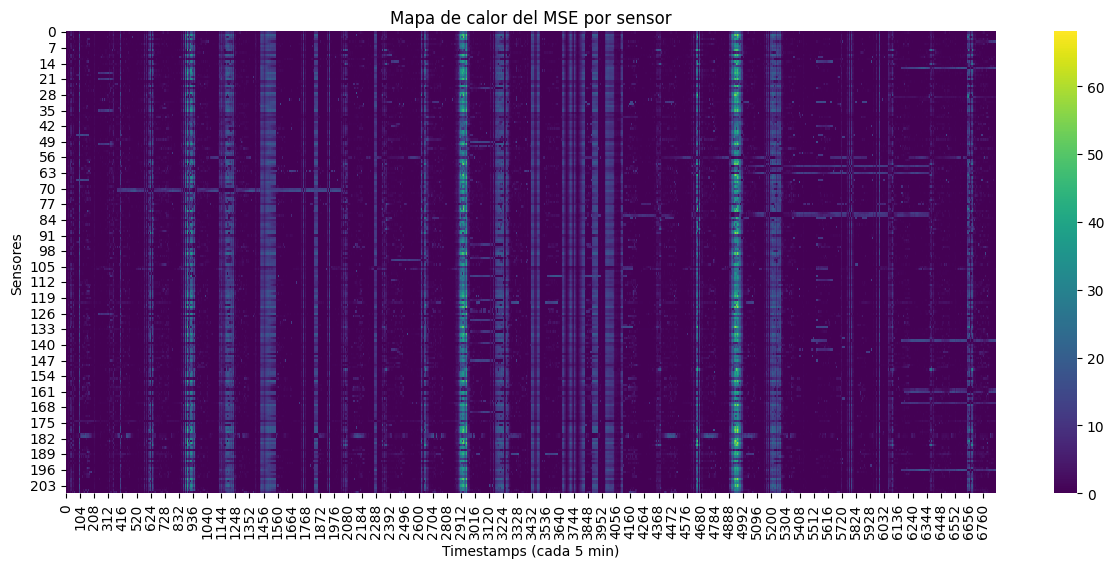

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# mse_matrix: [n_muestras, n_sensores] (ej: [6720, 207])
plt.figure(figsize=(15, 6))
sns.heatmap(mse_matrix.T.numpy(), cmap="viridis", cbar=True)
plt.xlabel("Timestamps (cada 5 min)")
plt.ylabel("Sensores")
plt.title("Mapa de calor del MSE por sensor")
plt.show()


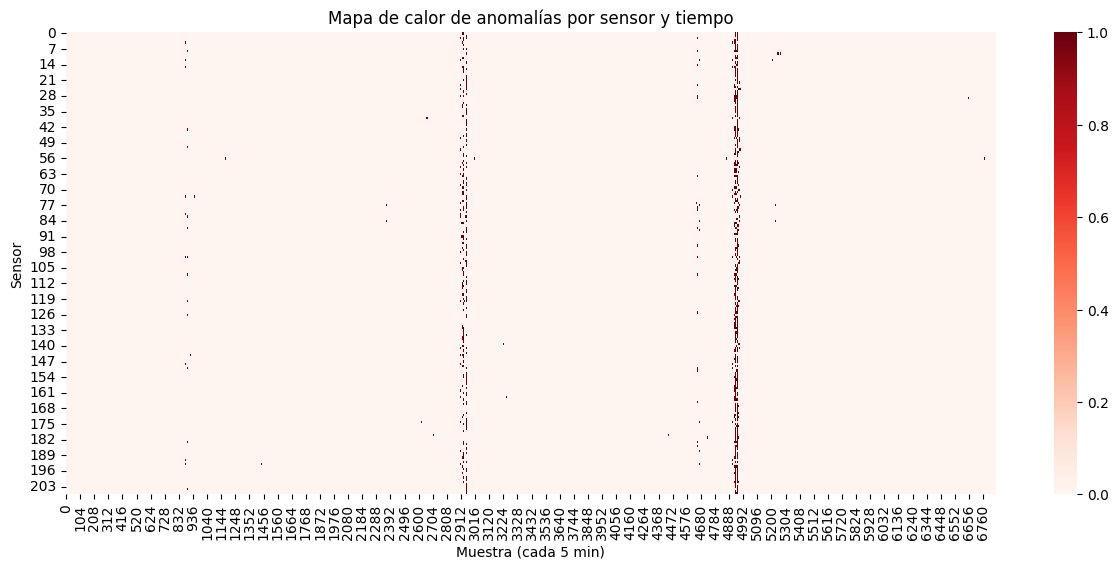

In [41]:
import seaborn as sns

# anomalies: [n_muestras, 207]
anomaly_matrix = anomalies.numpy().T  # ahora [207, n_muestras]

plt.figure(figsize=(15, 6))
sns.heatmap(anomaly_matrix, cmap="Reds", cbar=True)
plt.title("Mapa de calor de anomalías por sensor y tiempo")
plt.xlabel("Muestra (cada 5 min)")
plt.ylabel("Sensor")
plt.show()


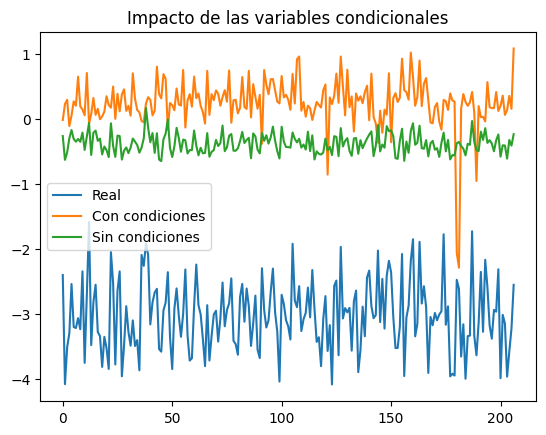

In [40]:
model.eval()
with torch.no_grad():
    x_sample = torch.tensor(x_test[100:101])
    c_normal = torch.tensor(c_test[100:101])
    c_fake = torch.zeros_like(c_normal)  # condiciones "neutrales"

    recon_normal = model(x_sample, c_normal)[0]
    recon_fake = model(x_sample, c_fake)[0]

    plt.plot(x_sample.numpy().flatten(), label="Real")
    plt.plot(recon_normal.numpy().flatten(), label="Con condiciones")
    plt.plot(recon_fake.numpy().flatten(), label="Sin condiciones")
    plt.legend()
    plt.title("Impacto de las variables condicionales")
    plt.show()


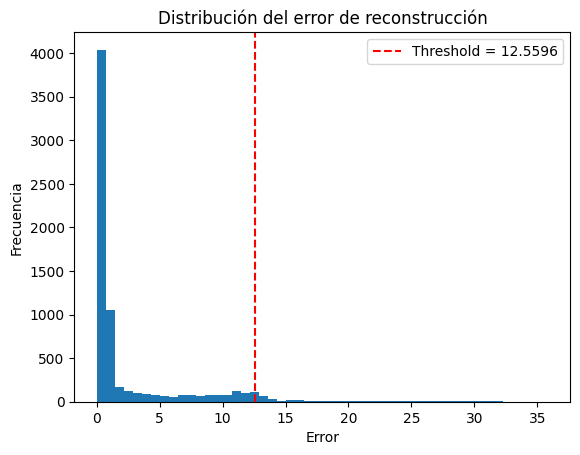

In [ ]:
# import matplotlib.pyplot as plt

# plt.hist(reconstruction_errors, bins=50)
# plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.4f}')
# plt.title("Distribución del error de reconstrucción")
# plt.xlabel("Error")
# plt.ylabel("Frecuencia")
# plt.legend()
# plt.show()


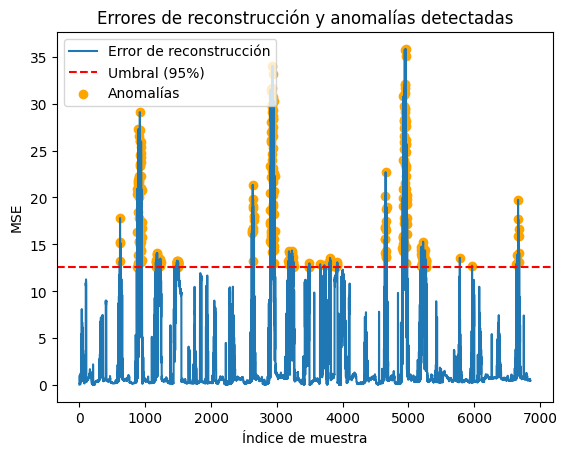

In [ ]:
# plt.plot(reconstruction_errors, label='Error de reconstrucción')
# plt.axhline(threshold, color='red', linestyle='--', label='Umbral (95%)')
# plt.scatter(np.where(anomalies)[0], np.array(reconstruction_errors)[anomalies], color='orange', label='Anomalías')
# plt.legend()
# plt.title("Errores de reconstrucción y anomalías detectadas")
# plt.xlabel("Índice de muestra")
# plt.ylabel("MSE")
# plt.show()


#### Sliding Windows

Sliding windows allow us to structure the time series data as sequences of fixed length, suitable for feeding into our VAE model.

The window size of 12 means each sample contains 12 consecutive timesteps (i.e., one hour of data).


In [10]:
def create_sliding_windows(data, window_size):
    X = []
    # for i in range(len(data) - window_size):
    #     X.append(data[i:i+window_size])
    i: int = 0
    while i < 34272:
        X.append(data[i:i+window_size])
        i= i + 12
    return np.array(X)

window_size = 12  # 12 pasos = 1 hora
X = create_sliding_windows(data_normalized, window_size)  # shape: (34260, 12, 207)
# 12 = rows
# 34260 =  
# 
print(X.shape)


(2856, 12, 207)


## Variational Autoencoder (VAE)

A Variational Autoencoder (VAE) is a type of generative model that learns to encode input data into a compressed latent space and then reconstruct it as accurately as possible. Unlike traditional autoencoders, VAEs add a probabilistic framework that makes the latent space continuous and meaningful, which is useful for tasks like anomaly detection.

### Main Components

#### 1. **Encoder**
The encoder network takes an input (e.g., a time window of traffic data) and maps it to a latent distribution. Instead of directly outputting a single latent vector, the encoder outputs:

- A mean vector $\mu$
- A standard deviation (or log variance) vector $\log(\sigma^2)$

These define a multivariate normal distribution from which we sample the latent variable $z$.

#### 2. **Latent Sampling**
To allow backpropagation through the sampling process, VAEs use the **reparameterization trick**:

$$
z = \mu + \sigma \cdot \epsilon \quad \text{where} \quad \epsilon \sim \mathcal{N}(0, I)
$$

This makes the sampling step differentiable.

#### 3. **Decoder**
The decoder takes the sampled latent variable $z$ and tries to reconstruct the original input data. The goal is to learn a meaningful latent space that can generate realistic reconstructions.

### Loss Function

The VAE optimizes two components in the loss:

1. **Reconstruction Loss** (e.g., Mean Squared Error):

$$
\mathcal{L}_{\text{recon}} = ||x - \hat{x}||^2
$$

This penalizes the model when its reconstruction $\hat{x}$ is far from the original input $x$.

> **Why use MSE as reconstruction loss?**
>
> Theoretically, we want to maximize the log-likelihood of the reconstruction, i.e., $\log p(x|z)$. If we assume that the decoder’s output is Gaussian with fixed variance (i.e., $p(x|z) = \mathcal{N}(\hat{x}, \sigma^2 I)$), then:
>
> $$
> \log p(x|z) = -\frac{1}{2\sigma^2} ||x - \hat{x}||^2 + \text{const}
> $$
>
> So minimizing the squared error (MSE) is equivalent to maximizing the likelihood. That’s why MSE acts as a **proxy** for the negative log-likelihood in practice.


2. **Kullback-Leibler (KL) Divergence**:

$$
\mathcal{L}_{\text{KL}} = D_{\text{KL}}(q(z|x) || p(z))
$$

This measures how much the learned latent distribution $q(z|x)$ (given by the encoder) deviates from the standard normal prior $p(z) = \mathcal{N}(0, I)$.

> **In practice**, the encoder outputs $\mu$ and $\log(\sigma^2)$, and the KL divergence between the approximate posterior and the prior can be computed in closed form:
>
> $$
> \mathcal{L}_{\text{KL}} = -\frac{1}{2} \sum \left(1 + \log(\sigma^2) - \mu^2 - \sigma^2\right)
> $$
>
> This encourages the model to keep the latent representations close to a standard normal distribution.


### Total Loss

The total loss combines both terms:

$$
\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{recon}} + \beta \cdot \mathcal{L}_{\text{KL}}
$$

where $\beta$ is a hyperparameter (commonly set to 1) that balances reconstruction accuracy and regularization. 

> **Important:** In theory, we want to **maximize** the Evidence Lower Bound (ELBO), which is:
>
> $$
> \text{ELBO}(x) = \mathbb{E}_{q(z|x)}[\log p(x|z)] - D_{\text{KL}}(q(z|x) || p(z))
> $$
>
> But in practice, optimization libraries **minimize** functions. So minimizing the total loss is equivalent to **maximizing the ELBO**.